In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import time

Using TensorFlow backend.


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
def normalization(matrix, max_val, min_val):
    new_matrix = np.array([((image - min_val) / (max_val - min_val)) for image in matrix])
    return new_matrix

In [4]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get min, and max value from training data set using all 60,000 samples
max_val = x_train.max()
# print("Maximal value: ", max_val)
min_val = x_train.min()

# Normalize training (x_train) and testing (x_test) data based on maximal/minimal values of the training data
x_train_scaled = normalization(x_train, max_val, min_val)
x_test_scaled = normalization(x_test, max_val, min_val)

image_size = x_train_scaled.shape[1]
reshaped_x_train_scaled = np.reshape(x_train_scaled, [-1, image_size, image_size, 1])
reshaped_x_test_scaled = np.reshape(x_test_scaled, [-1, image_size, image_size, 1])

In [5]:
print(image_size)
print(reshaped_x_train_scaled.shape, reshaped_x_test_scaled.shape)

28
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [6]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 200
kernel_size = 3
filters = 16
latent_dim = 5
epochs = 50

(None, 7, 7, 64)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
___________________________________________________________________________

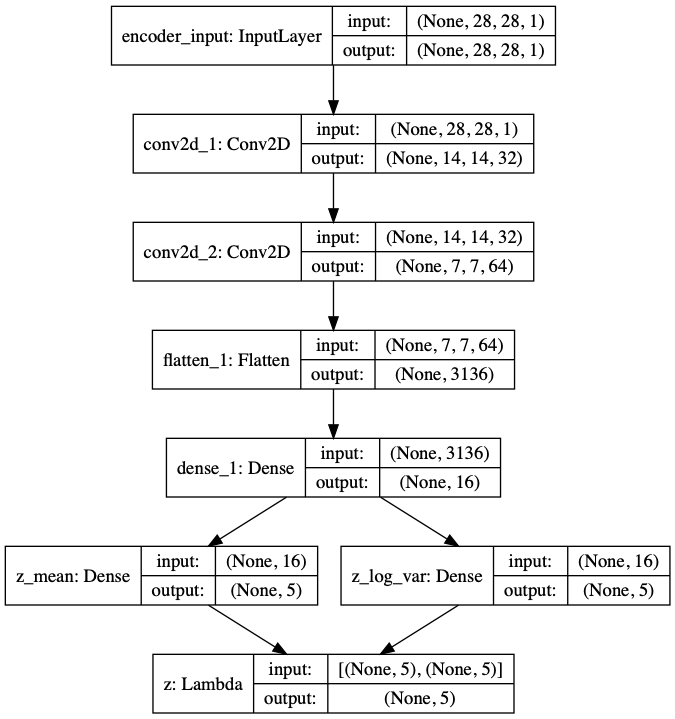

In [7]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    
# shape info needed to build decoder model
shape = K.int_shape(x)
print(shape)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              18816     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 74,497
Trainable params: 74,497
Non-trainable params: 0
_______________________________________________________

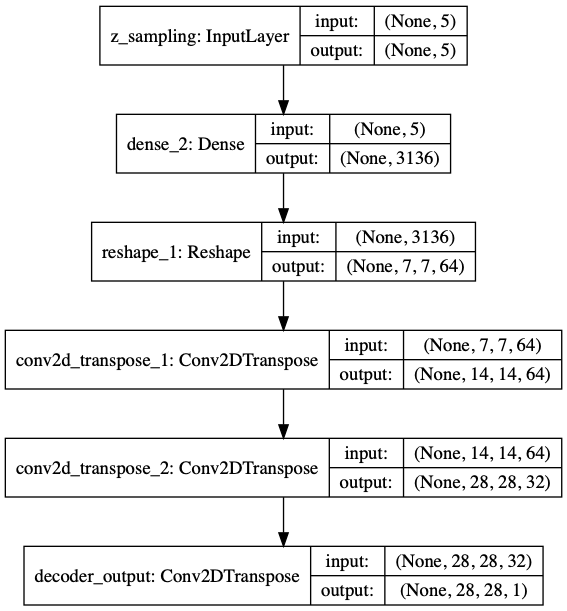

In [8]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

In [9]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 69178     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         74497     
Total params: 143,675
Trainable params: 143,675
Non-trainable params: 0
_________________________________________________________________


/Users/annanau/anaconda3/envs/tf2/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


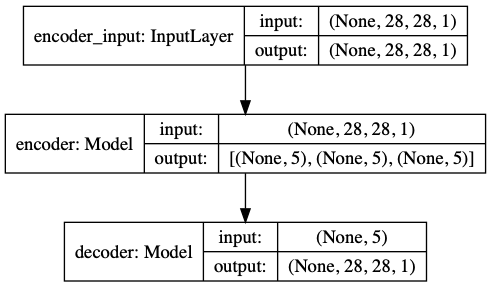

In [10]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

In [11]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


def acc_time(time_stamps):
    # accumulate all single time values
    accumulated_time = []
    acc_time = 0
    for time in time_stamps:
        acc_time += time
        accumulated_time.append(acc_time)
    # print(accumulated_time)
    return accumulated_time


def run_model(model, x_train, y_train, x_test, y_test_cat, y_test, class_names):
    print(model.summary())
    print()
    # compile the given model architecture
    model.compile(optimizer='adam')

    # call class for taking time stamps for each epoch
    time_callback_train = TimeHistory()
    

    # fit the model (train the network) and save metrics in variable history
    history = model.fit(x_train, epochs=2, batch_size=1000, validation_data=(x_test, None), callbacks=[time_callback_train])

    # store time stamps per epoch in variable
    times_train = time_callback_train.times
    print()
    print("Reported times per epoch: \n ", times_train)

    accumulated_time = acc_time(times_train)

    # Evaluate model using testing dataset
    test_start_time = time.time()
    test_loss = model.evaluate(x_test, batch_size=1000, verbose=2)
    print()
    print()
    print('Test Loss: {}'.format(test_loss))
    test_end_time = time.time() - test_start_time
    print('Time for Testing Data: ', test_end_time)

    # Plot training loss values vs epochs
    plt.plot(history.history['loss'])
    plt.title('Model Loss vs. Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training time vs epochs
    plt.plot(accumulated_time, history.history['loss'])
    plt.title('Model Loss vs. Time')
    plt.ylabel('Loss')
    plt.xlabel('Time in seconds')
    plt.legend(['Train'], loc='upper left')
    plt.show()

    return history

In [12]:
run_model(vae, reshaped_x_train_scaled, y_train_cat, reshaped_x_test_scaled, y_test_cat, y_test, class_names)

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 69178     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         74497     
Total params: 143,675
Trainable params: 143,675
Non-trainable params: 0
_________________________________________________________________
None



/Users/annanau/anaconda3/envs/tf2/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
10000/60000 [====>.........................] - ETA: 28s - loss: 127.6516

KeyboardInterrupt: 

In [34]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    #plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    print(figure)
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    print(grid_x)
    grid_y = np.linspace(-4, 4, n)[::-1]
    print(grid_y)
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[-2, 2,-3,3.5,2.1]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[-4.         -3.11111111 -2.22222222 -1.33333333 -0.44444444  0.44444444
  1.33333333  2.22222222  3.11111111  4.        ]
[ 4.          3.11111111  2.22222222  1.33333333  0.44444444 -0.44444444
 -1.33333333 -2.22222222 -3.11111111 -4.        ]


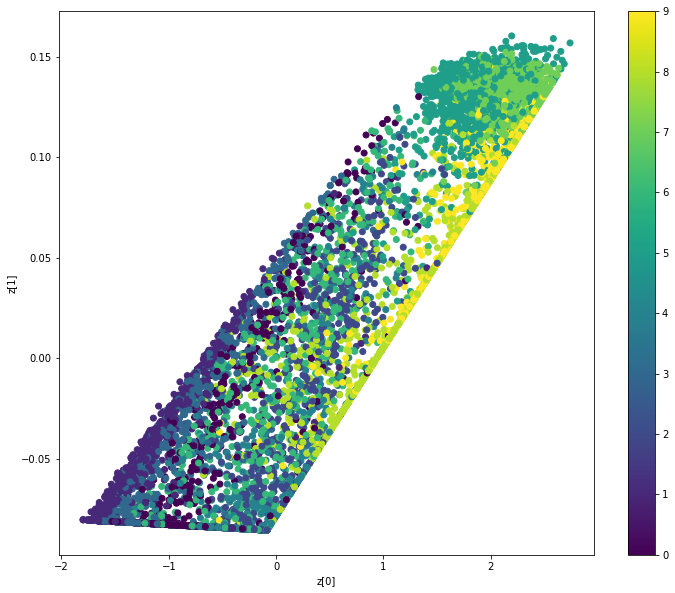

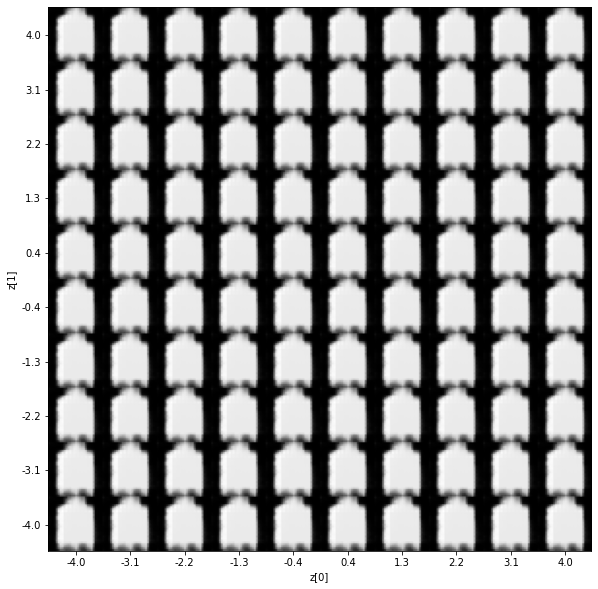

In [35]:
models = (encoder, decoder)
data = (reshaped_x_test_scaled, y_test) 
plot_results(models, data, batch_size=1000,model_name="vae_mlp")

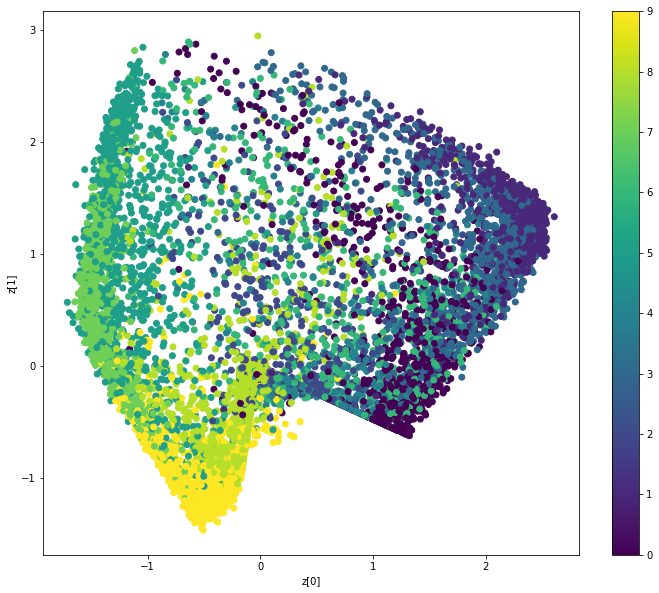

[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.  1. ]]
[[1.  2.  2.5 3.

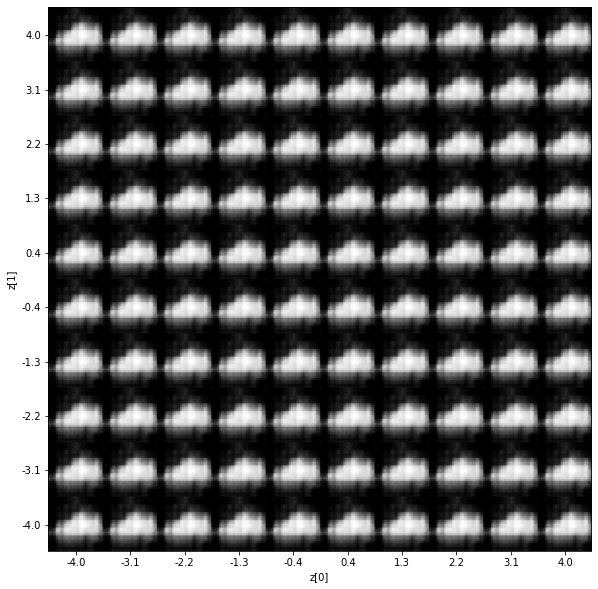

In [100]:
models = (encoder, decoder)
data = (reshaped_x_test_scaled, y_test) 
plot_results(models, data, batch_size=200,model_name="vae_mlp")